# Hypothesis

This notebook serves as a demo of the basic features and functionality of the Python tool **Hypothesis**.

## What is Hypothesis

Hypothesis is a tool that allows us to write and generate tests that generate and allow for fuzzing over a large variety of data without actually manually making all the tests. The key features mentioned are **property-based-testing** using `@given`, **strategies** for primitive and more complex data types, **shrinking** to find the simplest possible counter-example, and **stateful testing** to test with defined rules and checking invariants.

## 1. Basic Usage: `@given` and Strategies

The core of Hypothesis is the `@given` decorator, which takes **strategies** that define how to generate data. Let's test a simple `add` function.

In [1]:
import hypothesis
from hypothesis import given, strategies as st

def add(a, b):
    """A simple function to add two numbers."""
    return a + b

# This is a property-based test!
# It states that for any two integers a and b, add(a, b) should equal a + b.

@given(a=st.integers(), b=st.integers())
def test_addition_property(a, b):
    print(f"Testing with a={a}, b={b}") 
    assert add(a, b) == a + b

test_addition_property()

Testing with a=0, b=0
Testing with a=20071, b=0
Testing with a=20071, b=-593799844
Testing with a=125, b=0
Testing with a=125, b=5482974736779781910
Testing with a=-17252, b=0
Testing with a=-17252, b=-17931
Testing with a=24057, b=0
Testing with a=24057, b=-24998
Testing with a=12449, b=0
Testing with a=12449, b=22
Testing with a=12449, b=12449
Testing with a=-27324, b=26
Testing with a=-27324, b=-27324
Testing with a=-23286, b=25013
Testing with a=-23286, b=-23286
Testing with a=-40, b=32595
Testing with a=32595, b=32595
Testing with a=-5927, b=18418
Testing with a=18418, b=18418
Testing with a=-26391, b=18404
Testing with a=-26391, b=-26391
Testing with a=-25, b=5515
Testing with a=-25, b=-25
Testing with a=-63, b=-2601
Testing with a=-2601, b=-2601
Testing with a=-18013, b=-118
Testing with a=-18013, b=-18013
Testing with a=-3003092679546976358, b=-14278
Testing with a=-3003092679546976358, b=-3003092679546976358
Testing with a=17926, b=15
Testing with a=17926, b=17926
Testing with

Notice how Hypothesis tries a wide range of integers: positives, negatives, and zero. If the assertion had failed, Hypothesis would have reported it.

## 2. Shrinking, Counter-Examples, and Replaying

Hypothesis's superpower is finding the *simplest possible* failing example. This is called **shrinking**. Let's introduce a bug into a sorting function.

In [2]:
import os
import shutil
try:
    shutil.rmtree('.hypothesis')
except:
    print('no cache')


In [3]:
from hypothesis import find, strategies as st, settings, note
from typing import List

def buggy_sort(numbers: List[int]) -> List[int]:
    if 0 in numbers and 1 in numbers:
        return [999] #oh no our sort is wrong
    return sorted(numbers)

# defined strategy
list_strategy = st.lists(
    st.integers(min_value=-5, max_value=5),
    min_size=1,
    max_size=10
)

# ignore
seen_inputs = []

#ignore
def check_sort(numbers: List[int]):
    seen_inputs.append(numbers[:])  
    note(f"Checking example: {numbers}")
    assert buggy_sort(numbers) == sorted(numbers)

# --- Settings ---
@settings(verbosity=2, max_examples=1000, deadline=None)
def run_find():
    print("🔍 SSearching for example")
    failing_example = find(list_strategy, check_sort)
    print(f" {failing_example}")

run_find()

🔍 SSearching for example


AssertionError: 

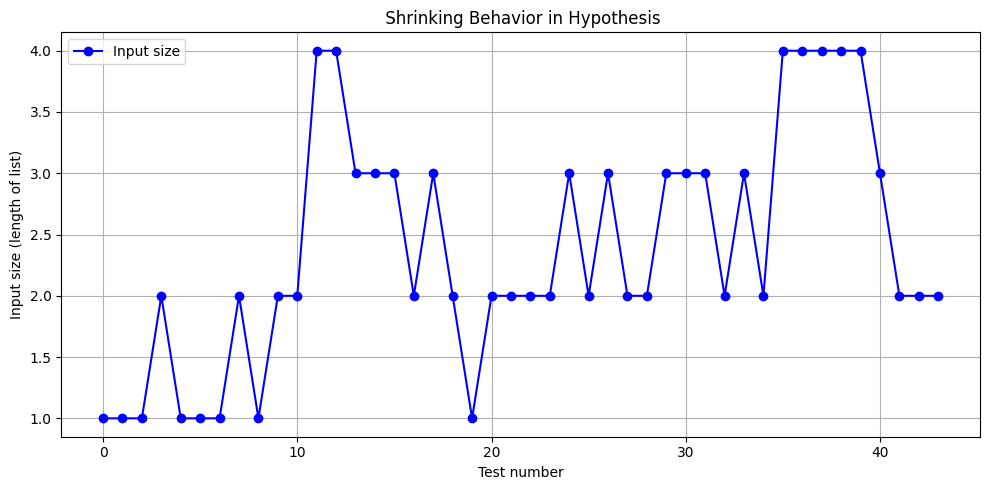

In [6]:
import matplotlib.pyplot as plt

sizes = [len(x) for x in seen_inputs]
plt.figure(figsize=(10, 5))
plt.plot(sizes, marker='o', linestyle='-', color='blue', label='Input size')
plt.xlabel('Test number')
plt.ylabel('Input size (length of list)')
plt.title(' Shrinking Behavior in Hypothesis')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

You might note it shrank it down to the simplest possible case that still causes the error.

#### Replaying Failures

When a test fails, Hypothesis saves the failing example. You can use the `@example` decorator to add it as a permanent regression test case, ensuring the bug never comes back.

In [7]:
from hypothesis import given, example, strategies as st


@given(st.lists(st.integers()))
@example([0, 1])  
def test_buggy_sort(numbers):
    try:
        assert buggy_sort(numbers) == sorted(numbers)
    except AssertionError:
        print(f"❌ Test failed for input: {numbers}")

test_buggy_sort()

print("Test with @example ran.")


❌ Test failed for input: [0, 1]
Test with @example ran.


## 3. More Features: Filters, Combining, and `assume()`

You can easily refine strategies.

In [8]:
from hypothesis import assume

# 1. Filtering: Create a strategy for positive integers
positive_integers = st.integers().filter(lambda x: x > 0)

# 2. Combining: Create a strategy for integers OR text
int_or_text = st.one_of(st.integers(), st.text())

# 3. `data()` and `assume()`: For complex, conditional logic inside your test
@given(st.data())
def test_division(data):
    # Use data.draw() to pull from a strategy
    numerator = data.draw(st.integers())
    denominator = data.draw(st.integers())
    
    # `assume` tells Hypothesis to discard this example and try a new one
    assume(denominator != 0)
    
    print(f"Testing {numerator} / {denominator}")
    assert isinstance(numerator / denominator, float)

test_division()

Testing 18240 / -1618331676
Testing 31144 / 28138
Testing -9758 / 29491
Testing -2043535464 / 56
Testing 32 / -22
Testing 997446698074727764 / -92
Testing 166520216488579097981463504449510507964 / -1049353351101241629
Testing 31639 / -31388
Testing -3544367244701708734 / -25482
Testing -33 / 8564
Testing 8564 / 8564
Testing -9619 / -10774
Testing -9619 / -9619
Testing -16435 / -111
Testing -16435 / -16435
Testing 791579709 / -53
Testing -53 / -53
Testing -2752 / -74
Testing -74 / -74
Testing 25850 / -119
Testing -119 / -119
Testing 10 / -4047
Testing 10 / 10
Testing 61 / -59
Testing 61 / 61
Testing 31992 / 5104378533841630765
Testing 5104378533841630765 / 5104378533841630765
Testing 56 / -107
Testing -107 / -107
Testing -66 / -15
Testing -15 / -15
Testing 13810 / -16725
Testing 13810 / 13810
Testing 1142849703 / 6918
Testing 1142849703 / 1142849703
Testing 32005 / -12
Testing 32005 / 32005
Testing 6910652603597639799 / -18053
Testing -18053 / -18053
Testing 6623706391443029858 / -9837


`assume()` is very powerful. It lets you reject test data that doesn't meet a precondition, without causing the test to fail.

## 4. Custom and Composite Strategies

What if you need to generate custom objects? The `@composite` decorator lets you build new strategies from existing ones.

In [ ]:
from hypothesis.strategies import composite
from dataclasses import dataclass

@dataclass
class User:
    id: int
    name: str

@composite
def user_strategy(draw):
    """A strategy to generate User objects."""
    # `draw` works like `data.draw()` from the previous example
    user_id = draw(st.integers(min_value=1))
    user_name = draw(st.text(min_size=3, max_size=20))
    return User(id=user_id, name=user_name)

@given(user=user_strategy())
def test_user_creation(user):
    print(f"Generated User: {user}")
    assert isinstance(user, User)
    assert user.id > 0
    assert len(user.name) >= 3

test_user_creation()

## 5. Stateful Testing

Hypothesis can even test stateful systems by generating sequences of actions and checking that invariants (rules that should always be true) hold.

Let's test a simple `SimpleStack` class.

In [ ]:
from hypothesis.stateful import RuleBasedStateMachine, rule, precondition

class SimpleStack:
    """A basic stack implementation."""
    def __init__(self):
        self._items = []
    
    def push(self, item):
        self._items.append(item)
        
    def pop(self):
        if not self._items:
            raise IndexError("pop from empty list")
        return self._items.pop()
    
    def is_empty(self):
        return not self._items
    
    @property
    def size(self):
        return len(self._items)

class StackStateMachine(RuleBasedStateMachine):
    """Defines the rules for testing our stack."""
    def __init__(self):
        super().__init__()
        self.stack = SimpleStack()
        self.model = [] # A simple list to model the stack's behavior
        
    @rule(item=st.integers())
    def push_item(self, item):
        """Rule for pushing an item."""
        self.stack.push(item)
        self.model.append(item)
        print(f"Pushed {item}")
        
    @rule()
    @precondition(lambda self: not self.stack.is_empty()) # Only run pop if not empty
    def pop_item(self):
        """Rule for popping an item."""
        popped_stack = self.stack.pop()
        popped_model = self.model.pop()
        print(f"Popped {popped_stack}")
        assert popped_stack == popped_model
    
    @rule()
    def check_invariants(self):
        """This rule checks properties that should always be true."""
        print("Checking invariants...")
        assert self.stack.size == len(self.model)
        assert self.stack.is_empty() == (not self.model)

# To run this, Hypothesis would execute a sequence of the rules defined above.
TestStack = StackStateMachine.TestCase
TestStack.runTest = lambda self: None # Suppress unittest's default runner

test_case = TestStack()
test_case.execute_step = test_case.execute_step
print("Running stateful test...")
# Manually run a few steps for demonstration
try:
    for i in range(10): # Run 10 random steps
        test_case.execute_step(test_case.steps.pop(0))
except (IndexError, AttributeError):
    pass # Stop if we run out of generated steps
print("\nStateful test finished.")

AttributeError: 'StackStateMachine.TestCase' object has no attribute 'execute_step'

epic thanks to the pogg0 goats Henry Shu, Inesh Chakrabarti, Ingrid Lee, Nathan Wei, Pritam Mukhopadhyay  